In [43]:
import torch.utils.data as data
import numpy as np
import torch.nn as nn
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms

In [44]:
BATCH_SIZE = 128
LEARN_RATE = 0.01
mps = torch.device("mps")

In [45]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data_set = ImageFolder("data/train", transform=transform)
n = len(data_set)
n_test = int(0.2 * n)
test_train = torch.utils.data.random_split(data_set, [0.2, 0.8])

train_set = test_train[1]
test_set = test_train[0]


In [46]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [47]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.batchnorm1 = nn.BatchNorm2d(8)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(4096, 128)
        self.dropout1 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(128, 50)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.maxpool1(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)

        return x

model = Net()

In [48]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARN_RATE)
model.to(device=mps)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (dropout1): Dropout(p=0.6, inplace=False)
  (fc2): Linear(in_features=128, out_features=50, bias=True)
)

Epoch: 0, loss train: 3.95, loss valid: 3.9
Epoch: 1, loss train: 3.91, loss valid: 3.89
Epoch: 2, loss train: 3.9, loss valid: 3.9
Epoch: 3, loss train: 3.91, loss valid: 3.89
Epoch: 4, loss train: 3.9, loss valid: 3.9
Epoch: 5, loss train: 3.9, loss valid: 3.9
Epoch: 6, loss train: 3.9, loss valid: 3.94
Epoch: 7, loss train: 3.9, loss valid: 3.89
Epoch: 8, loss train: 3.9, loss valid: 3.9
Epoch: 9, loss train: 3.9, loss valid: 3.89
Finished Training


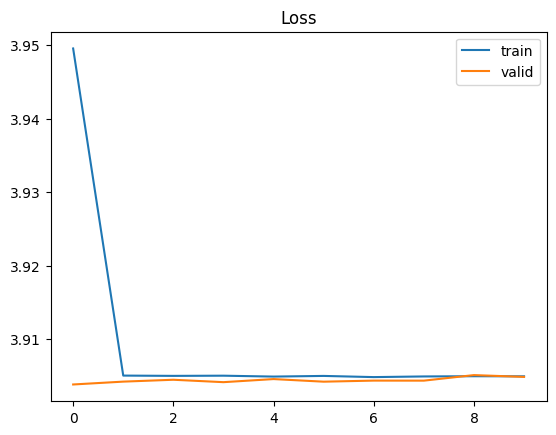

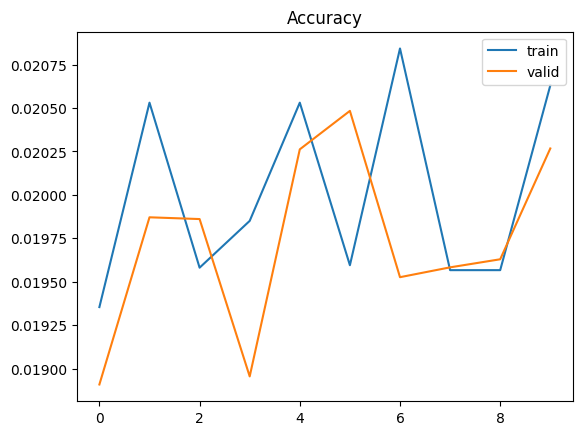

In [49]:
losses_train = []
losses_epoch_train = []
losses_test = []
losses_epoch_test = []

acc_train = []
acc_epoch_train = []
acc_test = []
acc_epoch_test = []

model.train()

for epoch in range(10):

    losses_epoch_train = []
    losses_epoch_test = []
    acc_epoch_test = []
    acc_epoch_train = []

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(mps), labels.to(mps)

        optimizer.zero_grad()

        predictions = model(inputs)
        loss = loss_fn(predictions, labels)
        loss.backward()
        optimizer.step()
        losses_epoch_train.append(loss.item())
        acc = (predictions.argmax(dim=1) == labels).sum() / predictions.shape[0]
        acc_epoch_train.append(acc.cpu())
    losses_train.append(np.mean(losses_epoch_train))
    acc_train.append(np.mean(acc_epoch_train))

    with torch.no_grad():
        for x, labels in test_loader:
            x, labels = x.to(mps), labels.to(mps)
            predictions = model(x)
            loss = loss_fn(predictions, labels)
            losses_epoch_test.append(loss.item())
            acc = (predictions.argmax(dim=1) == labels).sum() / predictions.shape[0]
            acc_epoch_test.append(acc.cpu())
        losses_test.append(np.mean(losses_epoch_test))
        acc_test.append(np.mean(acc_epoch_test))

    print(f"Epoch: {epoch}, loss train: {losses_train[-1]:.3}, loss valid: {losses_epoch_test[-1]:.3}")

plt.figure()
plt.plot(losses_train)
plt.plot(losses_test)
plt.title("Loss")
plt.legend(["train", "valid"])

plt.figure()
plt.title("Accuracy")
plt.plot(acc_train)
plt.plot(acc_test)
plt.legend(["train", "valid"])
print('Finished Training')